# Analysis code

Code for stats + figures.

Run this notebook from the `scripts` folder. Before running, ensure all default
values have been populated with `./scripts/update_param_list_in_model.yaml`.

## Preamble (always run)

In [1]:
# for plotting
%matplotlib inline

In [2]:
# imports
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

sns.set_theme()

from exp_utils import *
# from patsy import dmatrices

## ZeroSpeech libriABX analysis

In [3]:
# load zrc data
dfz = collate_data()
dfz.head(10)

,zrc.subset,zrc.speaker_mode,zrc.context_mode,zrc.granularity,zrc.score,zrc.pooling,zrc.seed,zrc.pca_style,name,feat_type,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,dev-clean,within,within,triphone,0.2064,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
1,dev-clean,across,within,triphone,0.2524,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
2,dev-other,within,within,triphone,0.2281,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
3,dev-other,across,within,triphone,0.2994,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
4,test-clean,within,within,triphone,0.1978,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
5,test-clean,across,within,triphone,0.2316,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
6,test-other,within,within,triphone,0.2282,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
7,test-other,across,within,triphone,0.3056,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
8,dev-clean,within,within,phoneme,0.1514,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
9,dev-clean,across,within,phoneme,0.1873,none,3459,full,cpc.trans64/version_12,raw,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0


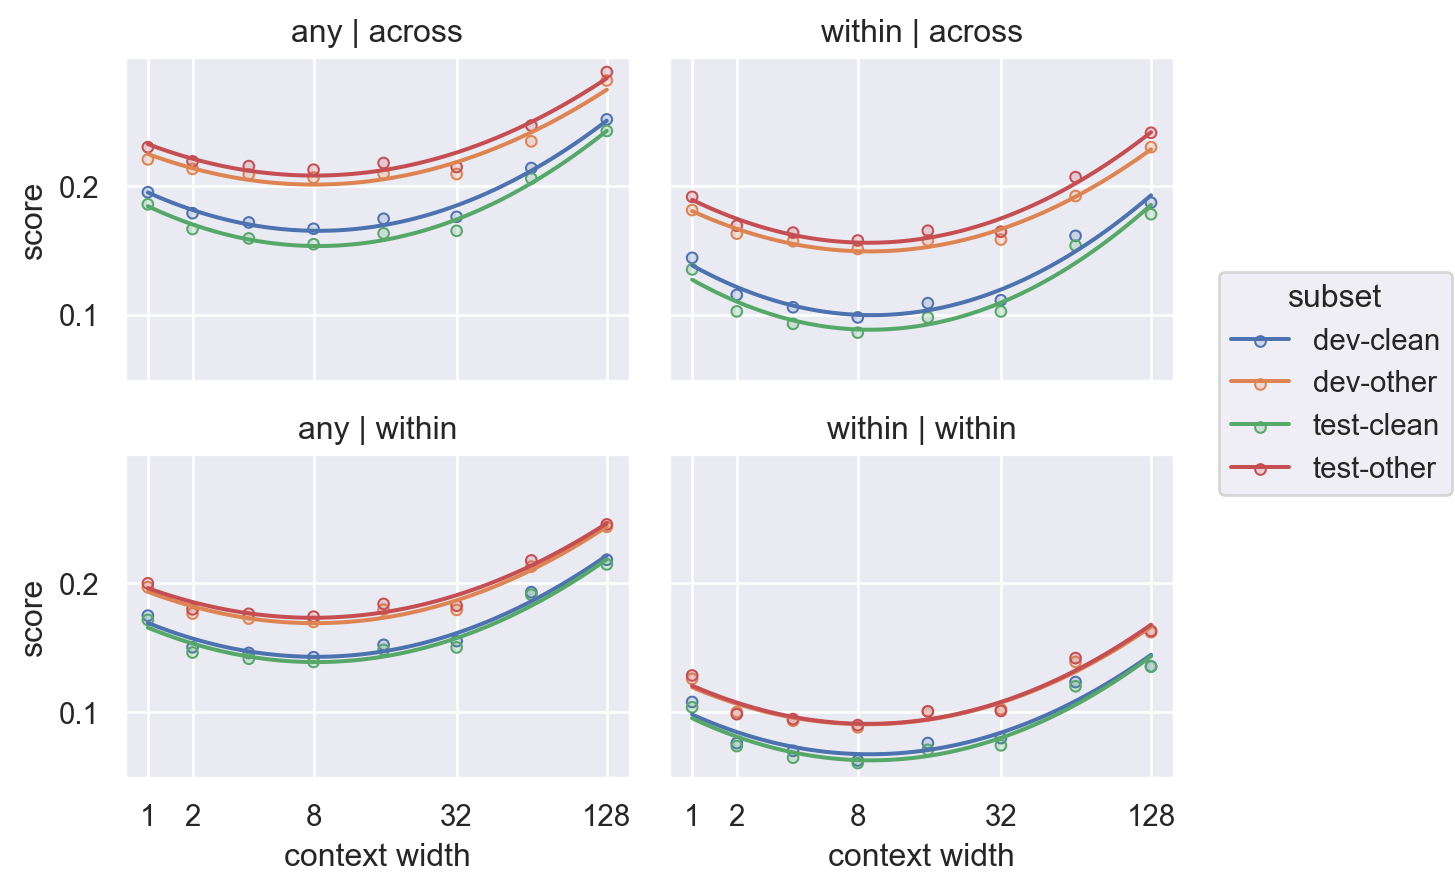

In [4]:
# plot libriABX scores across subsets and context windows w/ phoneme granularity
df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
})
df = filter_data_in(
    df, {"csa.max_width": (float(x) for x in range(1, 129)), "csa.num_layers": (0, 1)}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode",
    "zrc.context_mode", "training.cpc_loss.offset", "csa.num_layers"
)
plt = (
    so.Plot(df, x="csa.max_width", y="zrc.score", color="zrc.subset")
    .facet(row="zrc.speaker_mode", col="zrc.context_mode")
    .add(so.Dots())
    .add(so.Line(), so.PolyFit())
    .scale(
        x=(
            so.Continuous(trans="symlog")
            .tick(at=[1, 2, 8, 32, 128])
            .label(like='d', base=2)
        )
    )
    .label(x="context width", y="score", color="subset")
)
plt.save('../resources/libriabx_context_subset_phoneme.pdf')

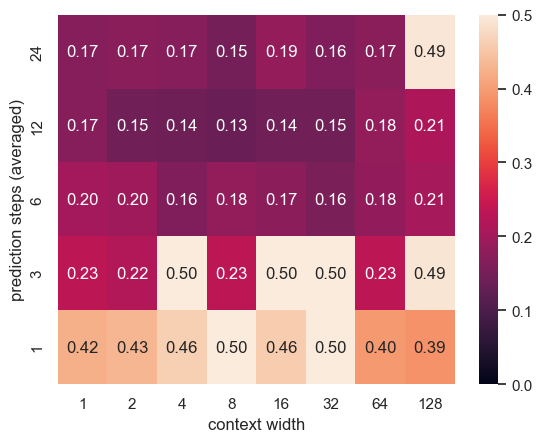

In [5]:
# plot libriABX score of context width vs prediction steps (averaged)
df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
})
df = filter_data_in(
    df, {"csa.max_width": (float(x) for x in range(1, 129)), "csa.num_layers": (0, 1)}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode",
    "zrc.context_mode", "training.cpc_loss.offset", "csa.num_layers",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.negative_samples",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plt = sns.heatmap(df, annot=True, fmt=".02f", vmin=0.0, vmax=0.5)
plt.set(xlabel='context width', ylabel='prediction steps (averaged)')
plt.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])
plt.set_yticklabels([f'{int(x):d}' for x in sorted(df.index, reverse=True)])
plt.get_figure().savefig("../resources/libriabx_prediction_steps_vs_width.pdf")

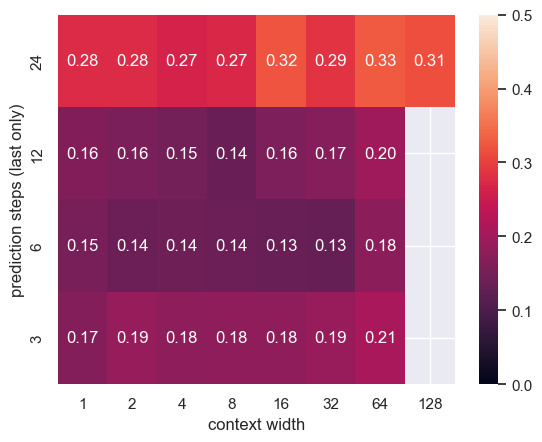

In [6]:
# plot libriABX score of context width vs prediction steps (last only)
df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.negative_samples": 128,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
})
df = filter_data_in(
    df, {"csa.max_width": range(1, 129), "csa.num_layers": (0, 1)}
)
idx = df['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df['training.cpc_loss.prediction_steps'] == n) & (df['training.cpc_loss.gutted_steps'] == (n - 1))
df = df.loc[idx]
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode",
    "zrc.context_mode", "training.cpc_loss.offset", "csa.num_layers",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.negative_samples", "training.cpc_loss.gutted_steps"
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plt = sns.heatmap(df, annot=True, fmt=".02f", vmin=0.0, vmax=0.5)
plt.set(xlabel='context width', ylabel='prediction steps (last only)')
plt.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])
plt.set_yticklabels([f'{int(x):d}' for x in sorted(df.index, reverse=True)])
plt.get_figure().savefig("../resources/libriabx_prediction_steps_vs_width_one.pdf")

## Tensorboard analysis

In [7]:
# load data
dft = collate_data("tb")
dft.head(10)

,tb.step,tb.epoch,tb.val_loss,name,feat_type,train_part,input_size,latent_type,context_type,conv.output_size,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,43745,22,0.090930,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
1,45647,23,0.089487,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
2,47549,24,0.085136,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
3,49451,25,0.081703,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
4,58961,30,0.089615,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
5,60863,31,0.075948,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
6,62765,32,0.077333,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
7,36137,18,0.098121,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
8,38039,19,0.099874,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0
9,39941,20,0.091648,bestrq.trans4/version_1,fbank-80,100,80,ff,csa,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200.0


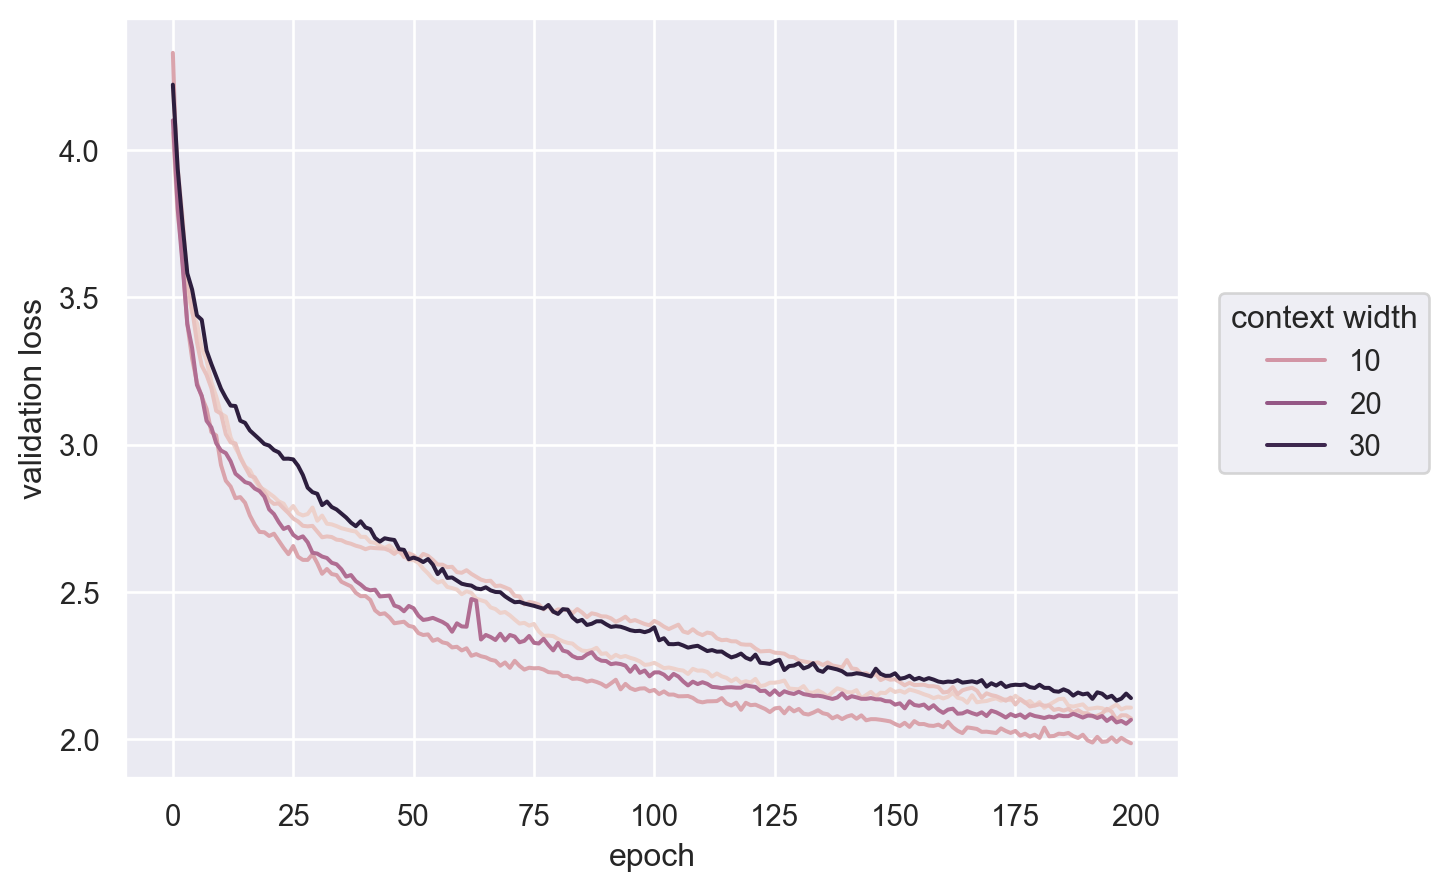

In [8]:
df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
})
df = filter_data_in(
    df, {"csa.max_width": (2, 4, 8, 16, 32), "csa.num_layers": (0, 1)}
).copy()
check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width", "csa.num_layers",
    "training.cpc_loss.offset"
)
df['csa.max_width'] = df['csa.max_width'].astype('int')#.astype('category')
plt = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    # .limit(y=(1.9, 3.0))
    .add(so.Line())
    .label(x="epoch", y="validation loss", color="context width")
    # .scale(color=so.Continuous(trans="log").tick(at=df['csa.max_width']))
)
plt.save('../resources/train_loss_vs_width.pdf')